In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import geopandas
import pandas

import copy
from shapely.geometry import MultiLineString, LineString, MultiPoint
import numpy as np
import json
from pathlib import Path

In [3]:
streets=geopandas.read_file('lines/streets.shp')

In [4]:
lpdata=geopandas.GeoDataFrame()
lpdata['geometry']=None
lpdata['street']=None

In [5]:
p=0
for i in range(len(streets)):
    line_string=streets.geometry[i]
    for k in np.arange(0.1, 0.9, 0.5):
        ip=line_string.interpolate(k, normalized=True)
        lpdata.loc[p, 'geometry']=ip
        lpdata.loc[p, 'street']=streets['osm_id'][i]
        p+=1

In [6]:
#Make shape file
out=Path("D:\GISC425\Project\shapefiles (1)\Lines\linepointstreet.shp") #CHANGE TO OWN DIRECTORY
lpdata.to_file(out)

In [7]:
lpdata.head()

,geometry,street
0,POINT (174.7803093057093 -41.29001958879277),5181907
1,POINT (174.7801789919197 -41.29024777336626),5181907
2,POINT (174.7698771456978 -41.29316914309541),5181912
3,POINT (174.7705698361428 -41.29338751969565),5181912
4,POINT (174.7787020359892 -41.29229139748418),5181919


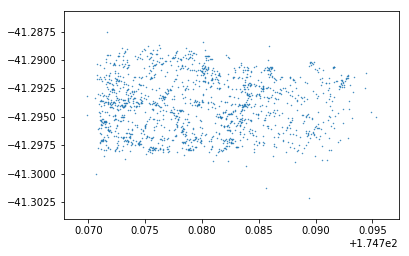

In [8]:
lpdata.plot(markersize=0.2)

In [9]:
spnt=geopandas.read_file('Lines/linepointstreet.shp')

In [10]:
spnt['lon'] = spnt['geometry'].x
spnt['lat'] = spnt['geometry'].y

In [11]:
array_spoints = np.array([[spnt['lon'][k], spnt['lat'][k]] for k in range(len(spnt))])

In [13]:
import scipy.spatial as spatial
vor = spatial.Voronoi(array_spoints)

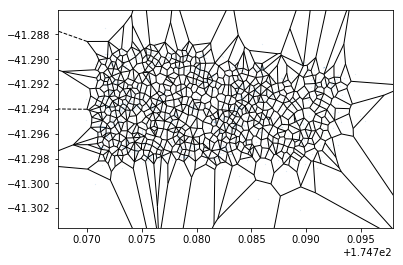

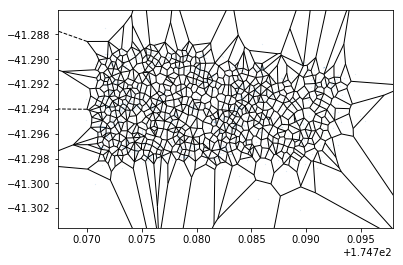

In [14]:
spatial.voronoi_plot_2d(vor, show_vertices=False, point_size=0.1)

In [15]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """Reconstruct infinite Voronoi regions in a
    2D diagram to finite regions.
    Source:
    [https://stackoverflow.com/a/20678647/1595060](https://stackoverflow.com/a/20678647/1595060)
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    new_regions = []
    new_vertices = vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()
    # Construct a map containing all ridges for a
    # given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points,
                                  vor.ridge_vertices):
        all_ridges.setdefault(
            p1, []).append((p2, v1, v2))
        all_ridges.setdefault(
            p2, []).append((p1, v1, v2))
    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]
        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue
        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue
            # Compute the missing endpoint of an
            # infinite ridge
            t = vor.points[p2] - \
                vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal
            midpoint = vor.points[[p1, p2]]. \
                mean(axis=0)
            direction = np.sign(
                np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + \
                direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        # Sort region counterclockwise.
        vs = np.asarray([new_vertices[v]
                         for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(
            vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[
            np.argsort(angles)]
        new_regions.append(new_region.tolist())
    return new_regions, np.asarray(new_vertices)

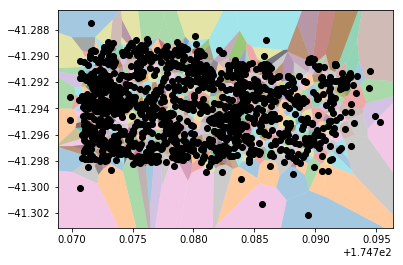

In [18]:
import matplotlib.pyplot as pyplot
regions, vertices = voronoi_finite_polygons_2d(vor)
for region in regions:
    polygon = vertices[region]
    pyplot.fill(*zip(*polygon), alpha=0.4)
    
pyplot.plot(spnt['lon'], spnt['lat'], 'ko')
pyplot.xlim(vor.min_bound[0] - 0.001, vor.max_bound[0] + 0.001)
pyplot.ylim(vor.min_bound[1] - 0.001, vor.max_bound[1] + 0.001)

pyplot.show()